In [1]:
ckpt_dir = '/home/sergei/ray_results/dots/main_fcn_b9909_00000_0_2021-01-22_03-44-19'

In [7]:
%load_ext autoreload
%autoreload 2
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
from causal_analysis.helpers import get_df_from_logdir, CPU_Unpickler
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.dots_learner import DotsLearner
from sparse_causal_model_learner_rl.config import Config
import pickle
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
load_config_files(['../sparse_causal_model_learner_rl/configs/dots.gin'])

['dots']

In [10]:
#learner = pickle.load(open(os.path.join(ckpt_dir, 'checkpoint_0', 'checkpoint'), 'rb'))
learner = DotsLearner(Config())

In [12]:
learner.collect_steps()

COLLECTING DATA!!!


In [13]:
data = learner._context['X_chw']

In [14]:
learner.collect_steps()

COLLECTING DATA!!!


In [15]:
data_test = learner._context['X_chw']

In [18]:
assert torch.norm(data - data_test).item() > 0

In [20]:
learner.create_trainables()

In [21]:
ae = learner.autoencoder.model

In [22]:
opt = torch.optim.Adam(ae.parameters(), lr=1e-2)

In [23]:
def loss_fcn(y_true, y_pred):
    delta = y_true - y_pred
    delta = torch.abs(delta)
    delta = delta ** 3.5
    delta = torch.mean(delta, dim=0)
    delta = torch.sum(delta)
    return delta

In [26]:
losses = []
losses_test = []
grads = []

test_every = 100

In [28]:
for i in tqdm(range(50)):
    opt.zero_grad()
    loss = loss_fcn(data, ae(data))
    loss.backward()
    
    grad = [x.grad for x in ae.parameters()]
    grad = np.max([torch.max(torch.abs(x)).item() for x in grad])
    grads.append(grad)
    
    opt.step()
    losses.append(loss.item())

In [30]:
grad = [x.grad for x in ae.parameters()]
grad = np.max([torch.max(torch.abs(x)).item() for x in grad])

In [31]:
grad

0.0017505651339888573

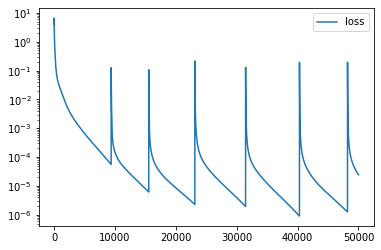

In [10]:
plt.plot(losses, label='loss')
# plt.plot(grads, label='grad')
plt.legend()
plt.yscale('log')